## **НЕЙРОННАЯ СЕТЬ**

In [71]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

initial_data = pd.read_csv('diabetes_dataset.csv', nrows=5000)

initial_data = initial_data.dropna()



initial_data = initial_data.drop(columns=['diabetes_stage', 'diabetes_risk_score'])


X = initial_data.drop('diagnosed_diabetes', axis=1).copy()
y = initial_data['diagnosed_diabetes']

le = LabelEncoder()
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = le.fit_transform(X[col].astype(str))

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Random Forest Feature Importance:")
print(feature_importance.head())

X = initial_data[feature_importance[feature_importance['importance'] > 0.01]['feature']]

columns = X.columns

Random Forest Feature Importance:
                               feature  importance
27                               hba1c    0.440095
25                glucose_postprandial    0.190556
24                     glucose_fasting    0.095866
8   physical_activity_minutes_per_week    0.018283
15                                 bmi    0.017804


#### Выбрали значимые признаки.


## **Создание сети**

In [72]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import datetime

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class DiabetesNeuralNetwork:
    def __init__(self, input_shape, hidden_layers=[64, 32], output_dim=1, 
                 learning_rate=0.001, activation='relu', dropout_rate=0.3):
        self.input_shape = input_shape
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.activation = activation
        self.dropout_rate = dropout_rate

        self.log_dir = "../logs/classification/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        os.makedirs(self.log_dir, exist_ok=True)
        
        self.tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=self.log_dir, 
            histogram_freq=1, 
            write_graph=True,
            write_images=True,
            update_freq='epoch'
        )

        self.early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        self.model = self._build_model()
    
    def _build_model(self):
        # этот тип модели позволяет собирать нашу сеть из слоев.
        model = tf.keras.Sequential()
        
        # входной слой
        model.add(tf.keras.layers.Input(shape=self.input_shape))
        
        # скрытые слои
        for units in self.hidden_layers:
            model.add(tf.keras.layers.Dense(units, activation=self.activation))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(self.dropout_rate))
        
        # выходной слой добавляем с Sigmoid, он будет выводить вероятность принадлежности к тому или иному классу
        model.add(tf.keras.layers.Dense(self.output_dim, activation='sigmoid'))
        
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='binary_crossentropy',
            metrics=[
                'accuracy', 
                'precision', 
                'recall', 
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.F1Score(name='f1_score')
            ]
        )
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[self.tensorboard_callback, self.early_stopping],
            verbose=1
        )
        return history
    
    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        metrics = {
            'loss': results[0],
            'accuracy': results[1],
            'precision': results[2],
            'recall': results[3],
            'auc': results[4],
            'f1_score': results[5]
        }
        return metrics
    
    def predict(self, X):
        return self.model.predict(X)
    
    def summary(self):
        return self.model.summary()

## Описание слоев:
##### Входной слой Input
##### Скрытые слои:
- ##### Dense - полносвязный слой с активационной функцией переданной извне
- ##### BatchNormalization - пакетная нормализация для ускорения обучения и стабильности нейронной сети.
- ##### Dropout - регуляризация, выключает в процентном соотношении нейроны, давая нейронной сети адаптироваться и учиться на разных нейронах.
##### Выходной слой Dense с активационной функцией Sigmoid, которая дает принадлежности к классам в процентном соотношении.

## **Написание различных архитектур для теста**

##### Будет использована активационная функция relu
##### ReLU (Rectified Linear Unit) — функция активации в нейронных сетях, широко используемая в глубоком обучении. Формула: f(x) = max(0, x).
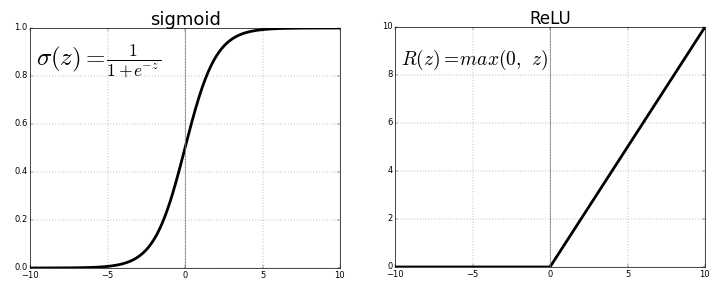

##### Особенности:
- ##### Если входное значение положительное, функция возвращает его без изменений.
- ##### Если входное значение равно нулю или отрицательное, функция выводит ноль.

In [73]:
def test_diabetes_models():   
    configs = [
        {
            'name': 'Базовая модель',
            'hidden_layers': [64, 32],
            'learning_rate': 0.001,
            'activation': 'relu',
            'dropout_rate': 0.3,
            'batch_size': 32
        },
        {
            'name': 'Глубокая модель',
            'hidden_layers': [128, 64, 32],
            'learning_rate': 0.001,
            'activation': 'relu',
            'dropout_rate': 0.2,
            'batch_size': 64
        },
        {
            'name': 'Очень глубокая модель',
            'hidden_layers': [128, 64, 32, 16],
            'learning_rate': 0.001,
            'activation': 'relu',
            'dropout_rate': 0.2,
            'batch_size': 32
        },
        {
            'name': 'Широкая модель',
            'hidden_layers': [256, 128],
            'learning_rate': 0.0001,
            'activation': 'relu',
            'dropout_rate': 0.5,
            'batch_size': 128
        }
    ]
    
    results = []
    
    for config in configs:
        print(f"\n--- Тестирование: {config['name']} ---")
        print(f"Архитектура: {config['hidden_layers']}")
        
        model = DiabetesNeuralNetwork(
            input_shape=(X_train.shape[1],),
            hidden_layers=config['hidden_layers'],
            learning_rate=config['learning_rate'],
            activation=config['activation'],
            dropout_rate=config['dropout_rate']
            )
        
        print("Архитектура модели:")
        model.summary()
        
        history = model.train(
            X_train, y_train, 
            X_test, y_test,
            epochs=100,
            batch_size=config['batch_size']
        )
        
        # Оценка модели
        metrics = model.evaluate(X_test, y_test)
        metrics = model.evaluate(X_test, y_test)
        
        results.append({
            'name': config['name'],
            'config': config,
            'metrics': metrics,
            'history': history,
            'model': model
        })
        
        print(f"Результаты: Точность={metrics['accuracy']:.4f}, AUC={metrics['auc']:.4f}, F1={metrics['f1_score']:.4f}")
    
    return results

## **Функция вывода графиков после завершения обучения нейросети**

In [74]:
def plot_diabetes_results(results):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    colors = ['blue', 'green', 'red', 'orange']
    
    for i, result in enumerate(results):
        axes[0, 0].plot(result['history'].history['accuracy'], 
                       color=colors[i], alpha=0.7,
                       label=f"{result['name']} (final: {result['metrics']['accuracy']:.3f})")
    axes[0, 0].set_title('Точность на тренировочных данных')
    axes[0, 0].set_xlabel('Эпоха')
    axes[0, 0].set_ylabel('Точность')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    for i, result in enumerate(results):
        axes[0, 1].plot(result['history'].history['loss'], 
                       color=colors[i], alpha=0.7,
                       label=f"{result['name']} (final: {result['metrics']['loss']:.3f})")
    axes[0, 1].set_title('Потери на тренировочных данных')
    axes[0, 1].set_xlabel('Эпоха')
    axes[0, 1].set_ylabel('Потери')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    for i, result in enumerate(results):
        axes[0, 2].plot(result['history'].history['auc'], 
                       color=colors[i], alpha=0.7,
                       label=f"{result['name']} (final: {result['metrics']['auc']:.3f})")
    axes[0, 2].set_title('AUC на тренировочных данных')
    axes[0, 2].set_xlabel('Эпоха')
    axes[0, 2].set_ylabel('AUC')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'auc', 'f1_score']
    metric_names = ['Точность', 'Precision', 'Recall', 'AUC', 'F1-Score']
    
    x_pos = np.arange(len(metrics_to_plot))
    width = 0.2
    
    for i, result in enumerate(results):
        values = [result['metrics'][metric] for metric in metrics_to_plot]
        axes[1, 0].bar(x_pos + i*width, values, width, label=result['name'], alpha=0.8)
    
    axes[1, 0].set_title('Сравнение финальных метрик')
    axes[1, 0].set_ylabel('Значение')
    axes[1, 0].set_xticks(x_pos + width*(len(results)-1)/2)
    axes[1, 0].set_xticklabels(metric_names, rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)


    
    plt.tight_layout()
    plt.savefig('diabetes_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix_for_best_model(best_model, X_test, y_test):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
    y_pred_proba = best_model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues')
    plt.title('Матрица ошибок - Лучшая модель')
    plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
    plt.show()

Запуск эксперимента с данными о диабете...

--- Тестирование: Базовая модель ---
Архитектура: [64, 32]
Архитектура модели:


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_111 (Dense)               │ (None, 64)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7335 - auc: 0.8000 - f1_score: 0.7500 - loss: 0.5759 - precision: 0.7903 - recall: 0.7567 - val_accuracy: 0.8290 - val_auc: 0.9172 - val_f1_score: 0.7692 - val_loss: 0.4011 - val_precision: 0.8358 - val_recall: 0.9040
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8210 - auc: 0.8946 - f1_score: 0.7500 - loss: 0.4277 - precision: 0.8636 - recall: 0.8333 - val_accuracy: 0.8470 - val_auc: 0.9262 - val_f1_score: 0.7692 - val_loss: 0.3553 - val_precision: 0.8665 - val_recall: 0.8928
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8338 - auc: 0.9049 - f1_score: 0.7500 - loss: 0.3950 - precision: 0.8725 - recall: 0.8467 - val_accuracy: 0.8580 - val_auc: 0.9296 - val_f1_score: 0.7692 - val_loss: 0.3378 - val_precision: 0.8876 - val_recall: 0.8848
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8338 - auc: 0.9098 - f1_score: 0.7500 - loss: 0.3782 - precision: 0.8731 - rec

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_114 (Dense)               │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,697 (53.50 KB)

 Trainable params: 13,249 (51.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6933 - auc: 0.7596 - f1_score: 0.7500 - loss: 0.6107 - precision: 0.7829 - recall: 0.6762 - val_accuracy: 0.8430 - val_auc: 0.9140 - val_f1_score: 0.7692 - val_loss: 0.4838 - val_precision: 0.8567 - val_recall: 0.8992
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8265 - auc: 0.8993 - f1_score: 0.7500 - loss: 0.4110 - precision: 0.8801 - recall: 0.8229 - val_accuracy: 0.8520 - val_auc: 0.9271 - val_f1_score: 0.7692 - val_loss: 0.3878 - val_precision: 0.8709 - val_recall: 0.8960
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8533 - auc: 0.9193 - f1_score: 0.7500 - loss: 0.3662 - precision: 0.9024 - recall: 0.8471 - val_accuracy: 0.8670 - val_auc: 0.9297 - val_f1_score: 0.7692 - val_loss: 0.3450 - val_precision: 0.8994 - val_recall: 0.8864
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8550 - auc: 0.9206 - f1_score: 0.7500 - loss: 0.3527 - precision: 0.9023 - recall: 0.

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_118 (Dense)               │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,273 (55.75 KB)

 Trainable params: 13,793 (53.88 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7165 - auc: 0.7856 - f1_score: 0.7500 - loss: 0.5836 - precision: 0.7796 - recall: 0.7354 - val_accuracy: 0.8150 - val_auc: 0.9132 - val_f1_score: 0.7692 - val_loss: 0.4473 - val_precision: 0.8073 - val_recall: 0.9248
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8123 - auc: 0.8831 - f1_score: 0.7500 - loss: 0.4385 - precision: 0.8562 - recall: 0.8258 - val_accuracy: 0.8560 - val_auc: 0.9227 - val_f1_score: 0.7692 - val_loss: 0.3676 - val_precision: 0.8836 - val_recall: 0.8864
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8345 - auc: 0.9023 - f1_score: 0.7500 - loss: 0.3973 - precision: 0.8742 - recall: 0.8458 - val_accuracy: 0.8540 - val_auc: 0.9244 - val_f1_score: 0.7692 - val_loss: 0.3446 - val_precision: 0.9052 - val_recall: 0.8560
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8393 - auc: 0.9061 - f1_score: 0.7500 - loss: 0.3831 - precision: 0.8845 - rec

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_123 (Dense)               │ (None, 256)            │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,425 (154.00 KB)

 Trainable params: 38,657 (151.00 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5717 - auc: 0.5973 - f1_score: 0.7500 - loss: 0.8859 - precision: 0.6635 - recall: 0.5808 - val_accuracy: 0.7400 - val_auc: 0.8163 - val_f1_score: 0.7692 - val_loss: 0.6054 - val_precision: 0.7343 - val_recall: 0.9152
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6740 - auc: 0.7351 - f1_score: 0.7500 - loss: 0.6966 - precision: 0.7566 - recall: 0.6733 - val_accuracy: 0.7420 - val_auc: 0.8993 - val_f1_score: 0.7692 - val_loss: 0.5299 - val_precision: 0.7187 - val_recall: 0.9648
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7325 - auc: 0.8035 - f1_score: 0.7500 - loss: 0.6032 - precision: 0.8113 - recall: 0.7221 - val_accuracy: 0.7590 - val_auc: 0.9181 - val_f1_score: 0.7692 - val_loss: 0.4854 - val_precision: 0.7330 - val_recall: 0.9664
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7508 - auc: 0.8293 - f1_score: 0.7500 - loss: 0.5645 - precision: 0.8237 - recall: 0.

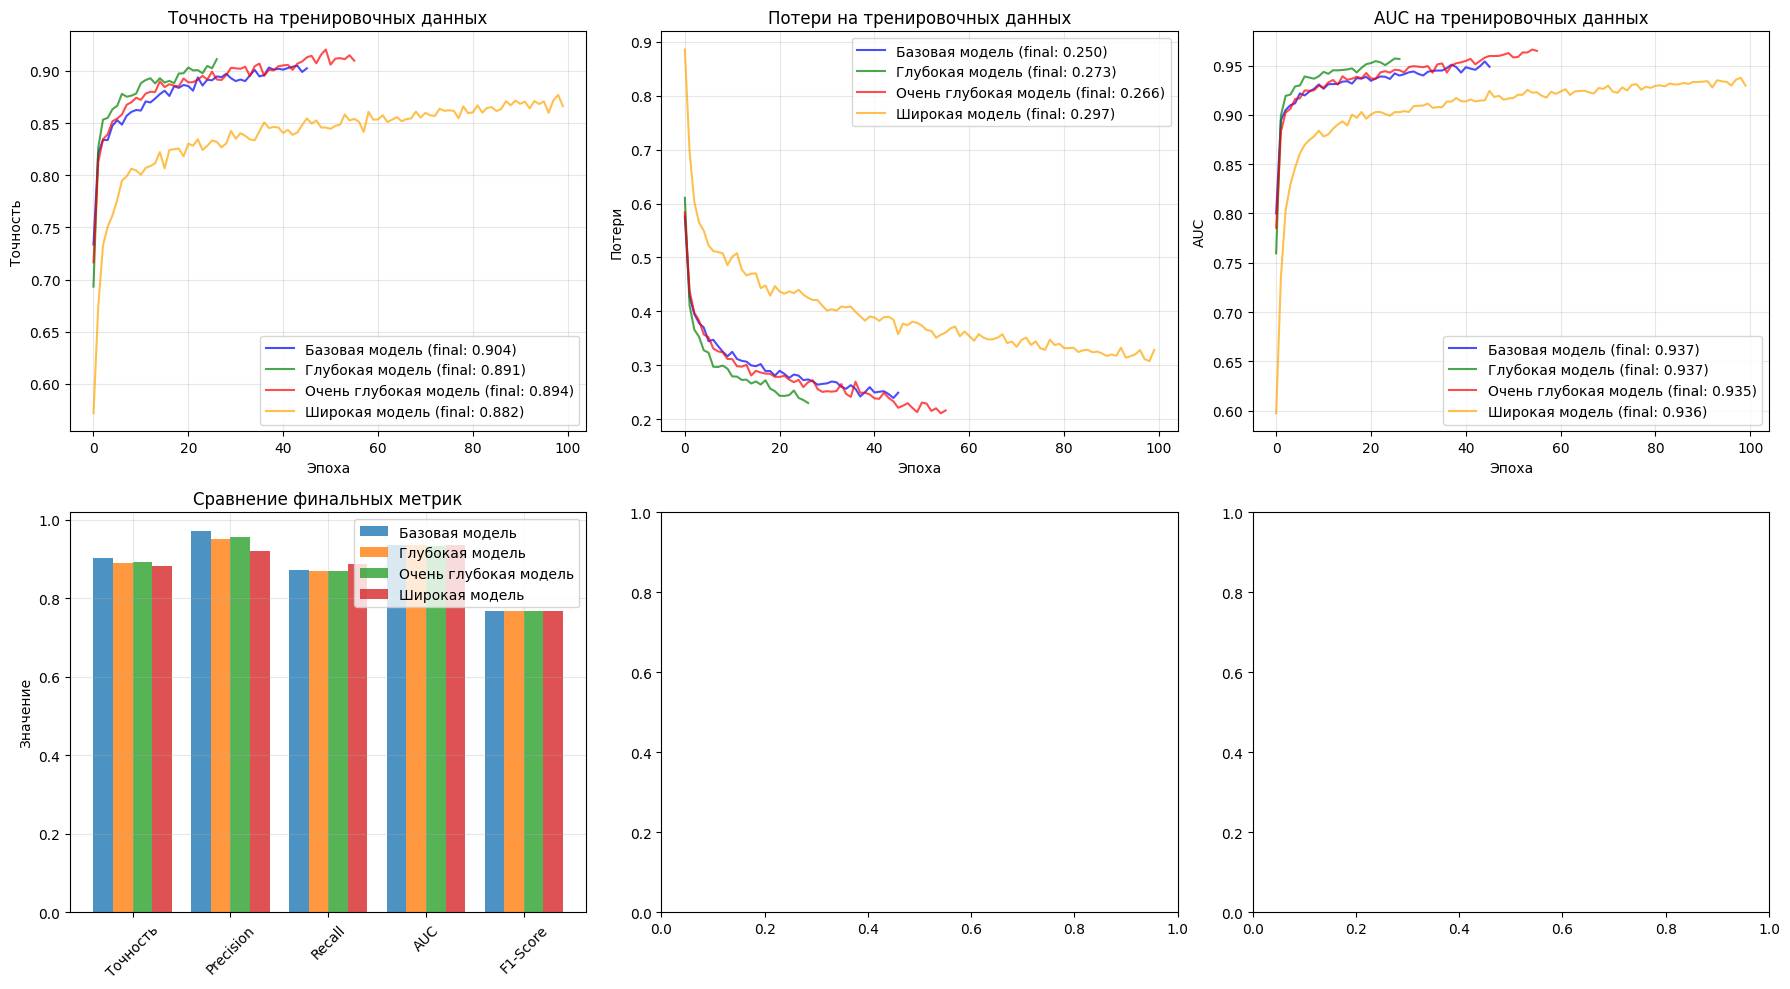


ЛУЧШАЯ МОДЕЛЬ: Базовая модель
Метрики:
   loss: 0.2501
   accuracy: 0.9040
   precision: 0.9715
   recall: 0.8720
   auc: 0.9370
   f1_score: 0.7692
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<Figure size 800x600 with 0 Axes>

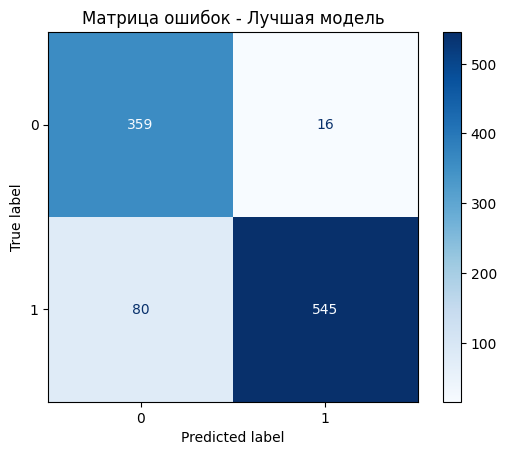


Команда для запуска tensorboard:
tensorboard --logdir ../logs/classification/
💾 Лучшая модель сохранена как 'best_diabetes_model.h5'


In [75]:
if __name__ == "__main__":
    print("Запуск эксперимента с данными о диабете...")
    
    # Тестирование различных конфигураций
    results = test_diabetes_models()
    
    # Визуализация результатов
    plot_diabetes_results(results)
    
    # Выбор лучшей модели
    best_result = max(results, key=lambda x: x['metrics']['f1_score'])
    print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_result['name']}")
    print(f"Метрики:")
    for metric, value in best_result['metrics'].items():
        print(f"   {metric}: {value:.4f}")
    
    # Матрица ошибок для лучшей модели
    plot_confusion_matrix_for_best_model(best_result['model'], X_test, y_test)
    
    print(f"\nКоманда для запуска tensorboard:")
    print(f"tensorboard --logdir ../logs/classification/")
    
    best_result['model'].model.save('best_diabetes_model.h5')
    print("💾 Лучшая модель сохранена как 'best_diabetes_model.h5'")

## **ФРАГМЕНТ ИЗ TENSOR BOARD**
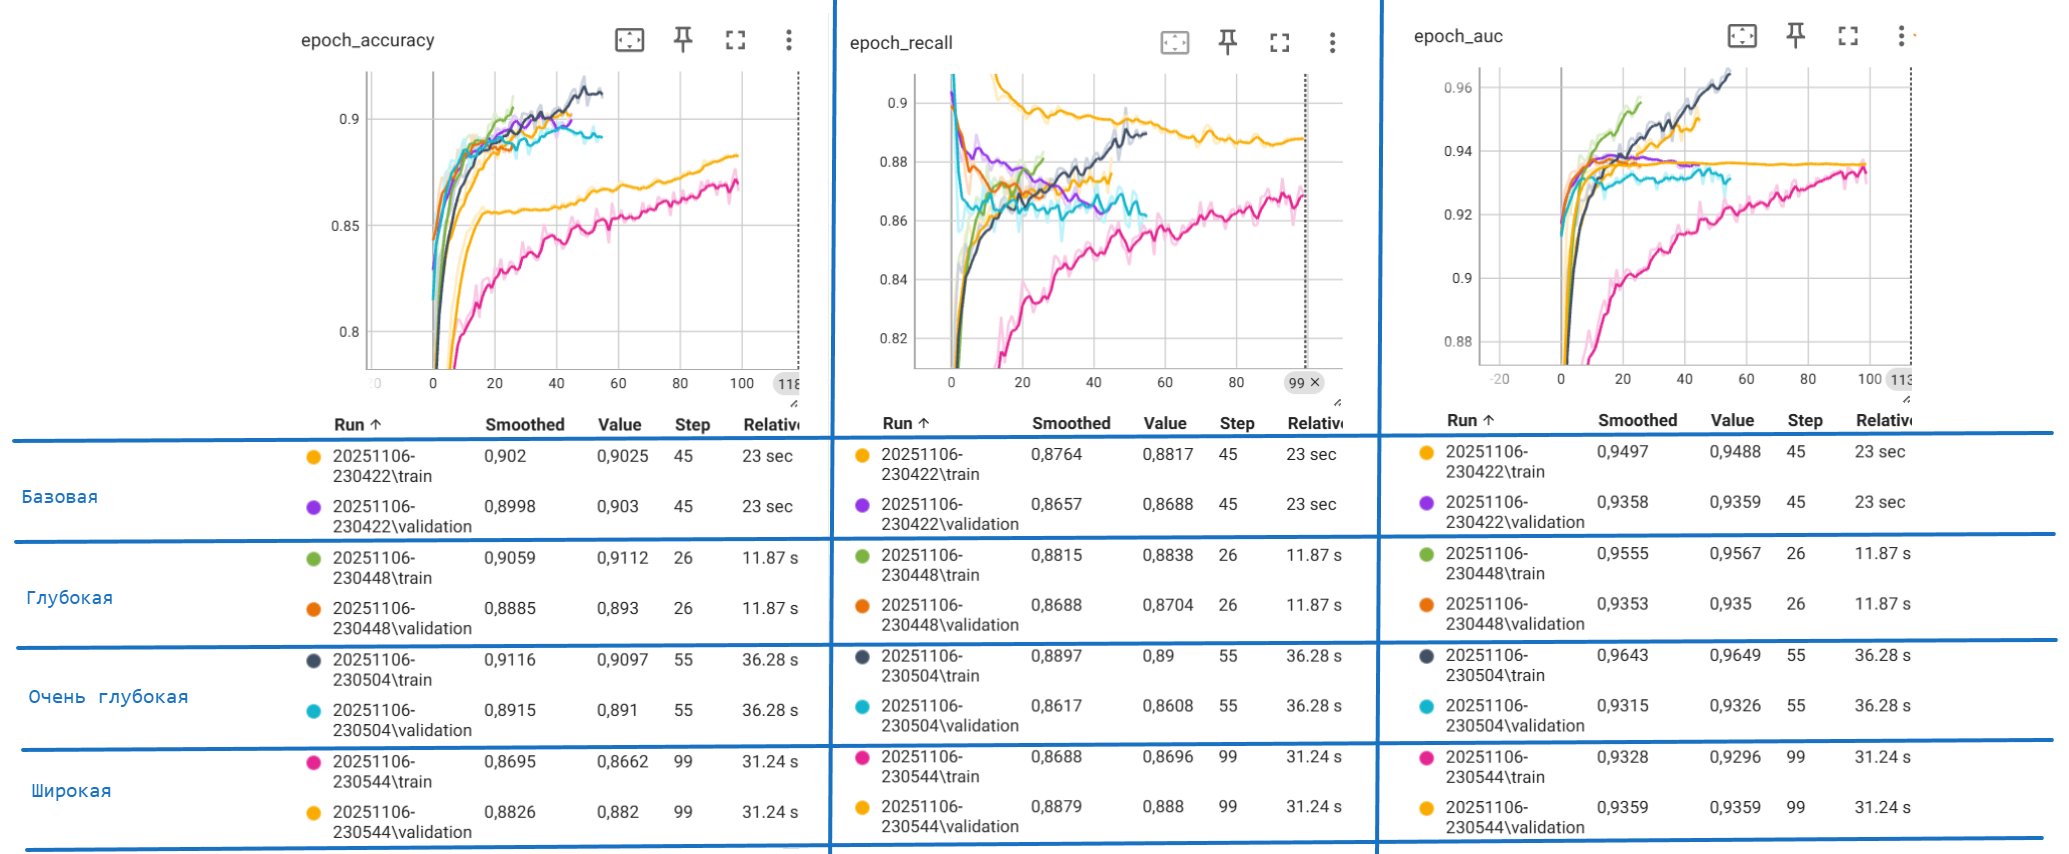

#### **ТОП-5 МЕТОДОВ!**
- #### Desicion TREE
- #### Нейронная сеть
- #### LDA
- #### SVM
- #### Наивный Байесовский Метод
- #### k-NN

## **ОБЩИЙ ВЫВОД**



### В ходе лабораторной были построены классификационные модели, и проанализированны их метрики. Было проанализировано влияние гиперпараметров на каждый метод. По метрикам лучшей моделью оказалась Decision TREE, метод Нейронная сеть практически не уступает в точности. Удалось достаточно точно классифицировать признаки.